# Optimal lockdown start time

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures
pyplot()

Plots.PyPlotBackend()

## Utility functions

In [2]:
# change plot fonts
bplot(p, s) = plot!(p, titlefont=font(s, "Times"), xguidefontsize=s-4
    , ytickfont=font(s-4, "Times"), margin=8mm, yguidefontsize=s-4
    , xtickfont = font(s-4, "Times"), legendfont = font(s-4, "Times"))

# this function will generate a T period of social distancing at time t0
sinput(t, ts, td) = if (t-ts<0 || t-ts-td>0) 0 else 1 end

sinput (generic function with 1 method)

# Numerical investigating functions

In [3]:
function numericalsearch(model, u0, pr, icomp)
    if(size(icomp,1)==1) pointer=2 else pointer=1 end
    # setup ode problem setup based on no lockdown mandate
    β, βl, γ = pr[1:3]
    tspn = (0., 1000.)
    prob = ODEProblem(model, u0, tspn, pr)  
    nlck = solve(prob, BS3(), reltol=1e-8,abstol=1e-8, saveat=1e-2)
    inf  = sum(nlck[icomp,:],dims=pointer)
    if (pointer==1) inf=inf' end
    v    = maximum(inf)
    vind = argmax(inf)
    if (pointer==1) vind=vind[1] end
    # max duration of lockdown
    maxduration = floor(Int,nlck.t[vind])
    A = v*ones(maxduration,1)
    O = v*ones(maxduration,1)
    # for each lockdown durations
    for td = 1:maxduration
        # simulation with start time formula (based on β=0)
        Is  = v/(2-exp(-γ*td)) 
        ts  = nlck.t[argmin(abs.(inf[1:vind].-Is))]
        pr[end-1:end] = [ts, td]
        prob = ODEProblem(model, u0, tspn, pr)
        appx = solve(prob,BS3(),reltol=1e-8,
            abstol=1e-8,saveat=1e-2)
        infa = sum(appx[icomp,:],dims=pointer)
        if(pointer==1) infa=infa' end
        A[td]= maximum(infa)      
        # computation search for numerical optimal start time
        tsr  = ts-maxduration:0.1:ts+maxduration
        peak = v
        # for each duration start time
        for i=1:size(tsr,1)
            pr[end-1] = tsr[i]
            prob = ODEProblem(model, u0, tspn, pr)
            sol  = solve(prob, BS3(), reltol=1e-8, 
                abstol=1e-8, saveat=1e-2)
            info = sum(sol[icomp,:],dims=pointer)
            if(pointer==1) info=info' end
            peak = min(peak,maximum(info))
        end
        O[td]= peak 
    end
    [A, O]
end

numericalsearch (generic function with 1 method)

In [4]:
function lockdown(model, u0, pr, icomp)
    A, O = numericalsearch(model, u0, pr,icomp)
    β, βl, γ, ts, td = pr
    td = 1:size(A,1)
    
    p1 = plot(td, A, label="approximation", 
        ylabel="infected peak", linewidth=3, 
        title=string(model))
    p1 = plot!(p1, td, O, label="optimal lockdown", 
        linewidth=3, linestyle=:dash, xlabel="Lockdown Duration")
    p1 = bplot(p1, 12)
    savefig(p1, "figures/"*string(model)*"_app1_"*string(βl)*".png")
    savefig(p1, "figures/"*string(model)*"_app1_"*string(βl)*".svg")
    
    p2 = plot(td, 100*abs.((O-A)./O), label=:false, 
        ylabel="% difference", linewidth=3, 
        title="βl/β="*string(round(βl/β,digits=3)))
    p2 = bplot(p2, 12)
    savefig(p2, "figures/"*string(model)*"_app2_"*string(βl)*".png")
    savefig(p2, "figures/"*string(model)*"_app2_"*string(βl)*".svg")
    
    p = plot(p1, p2, layout=(2,1))
    savefig(p, "figures/"*string(model)*"_app_"*string(βl)*".png")
    savefig(p, "figures/"*string(model)*"_app_"*string(βl)*".svg")
end

lockdown (generic function with 1 method)

# SIR

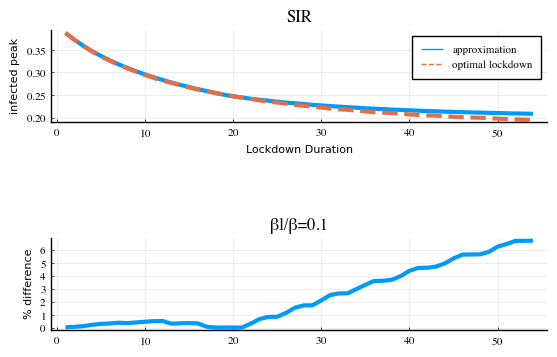

In [5]:
# model description ts and td are pr[end-1:end]
function SIR(dx,x,p,t)
    β, βl, γ, ts, td = p
    u = β - (β-βl).*sinput(t, ts, td)
    dx[1] = -u*x[1]*x[2]
    dx[2] = u*x[1]*x[2] - γ*x[2]
    dx[3] = γ*x[2]
end

pr = [0.2,0.02,0.05,0,0]
u0 = [1-1e-3, 1e-3, 0.0] 

icomp = 2
lockdown(SIR, u0, pr, icomp)

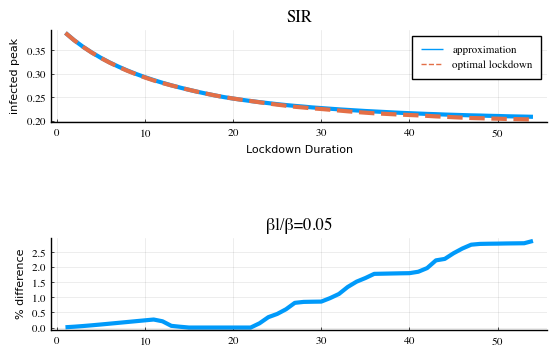

In [6]:
pr = [0.2,0.01,0.05,0,0]
lockdown(SIR, u0, pr, icomp)

# SAIR (I)

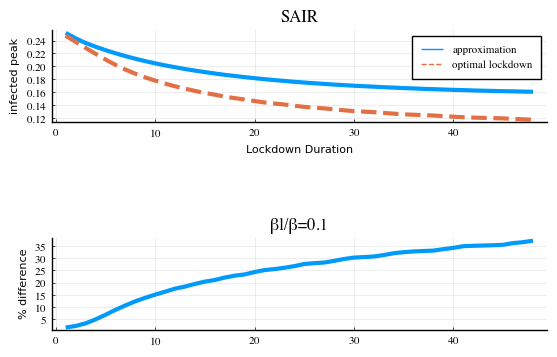

In [7]:
# model description
function SAIR(dx,x,p,t)
    βᵢ, βlᵢ, γᵢ, βₐ, βlₐ, γₐ, δ, ts, td = p
    u1 = βₐ - (βₐ-βlₐ).*sinput(t, ts, td)
    u2 = βᵢ - (βᵢ-βlᵢ).*sinput(t, ts, td)
    dx[1] = -u1*x[1]*x[2] - u2*x[1]*x[3]
    dx[2] = u1*x[1]*x[2] + u2*x[1]*x[3] - (δ+γₐ)*x[2]
    dx[3] = δ*x[2] - γᵢ*x[3]
    dx[4] = γₐ*x[2] + γᵢ*x[3]
end

# define initial values
u0 = [1-11e-4, 1e-3, 1e-4, 0.]
pr = [0.2, 0.02, 0.05, 0.3, 0.03, 0.09, 0.15, 0, 0]

icomp = 3
lockdown(SAIR, u0, pr, icomp)

# SAIR (A)

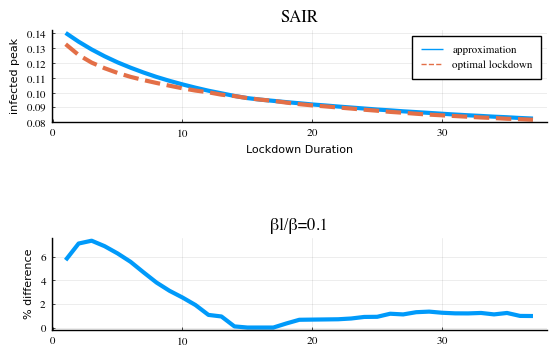

In [8]:
icomp = 2
lockdown(SAIR, u0, pr, icomp)

# SAIR (I+A)

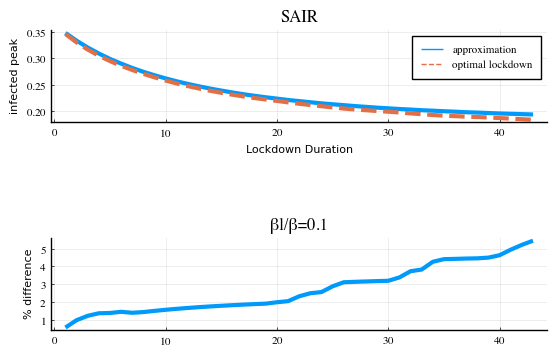

In [9]:
icomp = 2:3
lockdown(SAIR, u0, pr, icomp)

# SIDARTHE (I+D+A+R+T)

In [ ]:
# SIDARHE model description
function SIDARTHE(du,u,p,t)
    β, βl = p[1:2]
    s = p[3:18]
    N, ts, td = p[19:21]
    beta  = β - (β-βl).*sinput(t, ts, td)
    du[1] = -β*u[1]*(s[1]*u[2]+s[2]*u[3]+s[3]*u[4]+s[4]*u[5])/N
    du[2] = β*u[1]*(s[1]*u[2]+s[2]*u[3]+s[3]*u[4]+s[4]*u[5])/N 
                - (s[5]+s[6]+s[7])*u[2]
    du[3] = s[5]*u[2] - (s[8]+s[9])*u[3]
    du[4] = s[6]*u[2] - (s[10]+s[11]+s[12])*u[4]
    du[5] = s[8]*u[3] + s[10]*u[4] - (s[13]+s[14])*u[5]
    du[6] = s[11]*u[4] + s[13]*u[5] - (s[15]+s[16])*u[6]
    du[7] = s[7]*u[2] + s[9]*u[3] + s[12]*u[4] + s[14]*u[5] 
                + s[15]*u[6]
    du[8] = s[16]*u[6]
end

# parameters and initial conditions
pr = [1, 0.1, 0.570, 0.011, 0.456, 0.011, 0.171, 0.371, 0.125, 
    0.125, 0.012, 0.027, 0.003, 0.034, 0.034, 0.017, 0.017, 
    0.017, 1e7, 0, 0]
u0 = [1e7-83.333, 83.333, 0, 0, 0, 0, 0, 0]

icomp = 2:6
lockdown(SIDARTHE, u0, pr, icomp)

# Provenance

In [ ]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")  